In [42]:
import numpy as np

class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = int(n_components)
        self.mean_ = None                 # (d,)
        self.components_ = None           # (n_components, d) principal axes (rows)
        self.explained_variance_ = None   # (n_components,)
        self.explained_variance_ratio_ = None  # (n_components,)
        self.singular_values_ = None      # (n_components,)
        self.fitted_ = False

    def fit(self, X):
        """
        Center X, compute top n_components principal axes via SVD.
        X: (n_samples, n_features)
        """
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        k = self.n_components if self.n_components <= min(n, d) else min(n, d)

        # 1) center
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2) SVD of centered data
        # Xc = U S V^T  -> rows of V^T are principal directions
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

        # 3) keep top k components
        self.components_ = Vt[:k, :]                         # (k, d)
        # explained variance of each PC: S^2 / (n-1)
        var = (S**2) / (n - 1)
        self.explained_variance_ = var[:k]
        self.singular_values_ = S[:k]
        total_var = var.sum()
        self.explained_variance_ratio_ = self.explained_variance_ / total_var if total_var > 0 else np.zeros_like(self.explained_variance_)

        self.n_components = k
        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Project X onto learned principal axes.
        Returns Z of shape (n_samples, n_components)
        """
        if not self.fitted_:
            print("transform: call fit(X) first.")
            return None
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        Z = Xc @ self.components_.T
        return Z

    def checkPCA(self, X):
        """
        Quick sanity checks:
          1) transformed shape is (n_samples, n_components)
          2) components are (approximately) orthonormal
          3) explained variance is non-increasing
        Returns True if all pass, else False.
        """
        if not self.fitted_:
            print("checkPCA: call fit(X) first.")
            return False

        Z = self.transform(X)
        ok_shape = (Z is not None) and (Z.shape[1] == self.n_components)

        # components orthonormal: C C^T ≈ I
        C = self.components_
        I = C @ C.T
        ok_ortho = np.allclose(I, np.eye(self.n_components), atol=1e-6)

        # variance non-increasing
        ev = self.explained_variance_
        ok_monotonic = np.all(ev[:-1] >= ev[1:] - 1e-12)

        return bool(ok_shape and ok_ortho and ok_monotonic)


In [43]:
import numpy as np
import struct

def load_idx_images(path):
    with open(path, 'rb') as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def load_idx_labels(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data


In [44]:
X_train = load_idx_images("archive/train-images.idx3-ubyte")
y_train = load_idx_labels("archive/train-labels.idx1-ubyte")

X_test  = load_idx_images("archive/t10k-images.idx3-ubyte")
y_test  = load_idx_labels("archive/t10k-labels.idx1-ubyte")

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)


In [45]:
X = X_train.reshape(len(X_train), -1).astype(np.float64) / 255.0
print("Flattened X:", X.shape)  # should be (60000, 784)


Flattened X: (60000, 784)


In [46]:
pca = PCAFromScratch(n_components=50).fit(X)
Z = pca.transform(X)
print("Reduced shape:", Z.shape)
print("checkPCA:", pca.checkPCA(X))


Reduced shape: (60000, 50)
checkPCA: True


## PCA Functions: Mathematical Summary

### 1. `fit()` (Principal components)
We center the data:
$$
X_c = X - \mu, \quad \mu = \frac{1}{n}\sum_{i=1}^n X_i
$$

Covariance:
$$
\Sigma = \frac{1}{n-1} X_c^\top X_c
$$

SVD:
$$
X_c = U S V^\top
$$

- Eigenvectors (principal axes): rows of \(V^\top\)  
- Eigenvalues: 
$$
\lambda_j = \frac{S_j^2}{n-1}
$$

---

### 2. `transform()` (Projection)
Project onto top \(k\) components:
$$
Z = (X - \mu) V_k
$$

X represents the data matrix with n rows (samples) and d columns (features).

Vk represents the top k eigenvectors stacked together, which form the transformation matrix with d rows and k columns.

Z represents the transformed data after projection, with n rows (samples) and k columns (reduced features).

---

### 3. `checkPCA()` (Validation)
1. Shape:
$$
Z \in \mathbb{R}^{n \times k}
$$

2. Orthonormality:
$$
V_k^\top V_k = I_k
$$

3. Eigenvalue ordering:
$$
\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_k
$$


In [47]:
import numpy as np
import struct

def load_idx_images(path):
    with open(path, 'rb') as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def load_idx_labels(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# Adjust paths if needed
X_train = load_idx_images("archive/train-images.idx3-ubyte")
y_train = load_idx_labels("archive/train-labels.idx1-ubyte")

print("Train set:", X_train.shape, y_train.shape)  # (60000,28,28) (60000,)


Train set: (60000, 28, 28) (60000,)


In [ ]:
import numpy as np

subset_X, subset_y = [], []
for digit in range(10):
    idx = np.where(y_train == digit)[0]
    chosen = np.random.choice(idx, 100, replace=False) 
    subset_X.append(X_train[chosen])
    subset_y.append(y_train[chosen])

subset_X = np.vstack(subset_X)
subset_y = np.hstack(subset_y)

print("Balanced subset:", subset_X.shape, subset_y.shape)


Balanced subset: (1000, 28, 28) (1000,)


In [ ]:
# after building subset_X (1000,28,28) and subset_y (1000,)
X = subset_X.reshape(len(subset_X), -1).astype(float) / 255.0
y = subset_y.copy()

rng = np.random.default_rng(42)          
perm = rng.permutation(len(y))
X = X[perm]
y = y[perm]

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1000, 784) y shape: (1000,)


In [ ]:
dims = [500, 300, 150, 30]
results = {}

for d in dims:
    pca = PCAFromScratch(n_components=d).fit(X)
    Z = pca.transform(X)
    X_hat = Z @ pca.components_ + pca.mean_   
    results[d] = {"pca": pca, "Z": Z, "X_hat": X_hat}


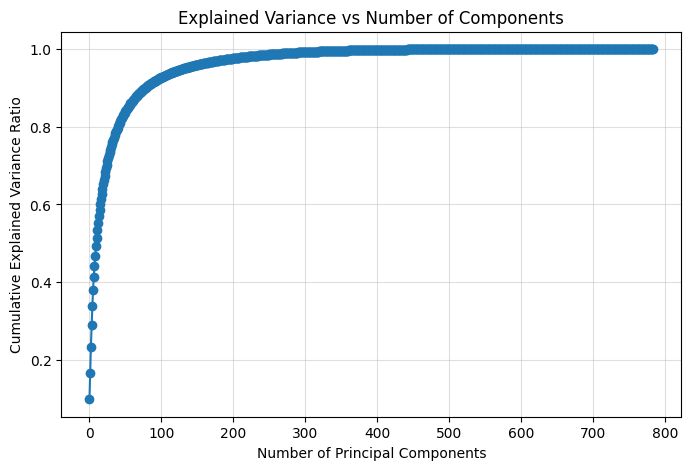

In [51]:
import matplotlib.pyplot as plt

pca_full = PCAFromScratch(n_components=784).fit(X)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance vs Number of Components")
plt.grid(True, alpha=0.4)
plt.show()


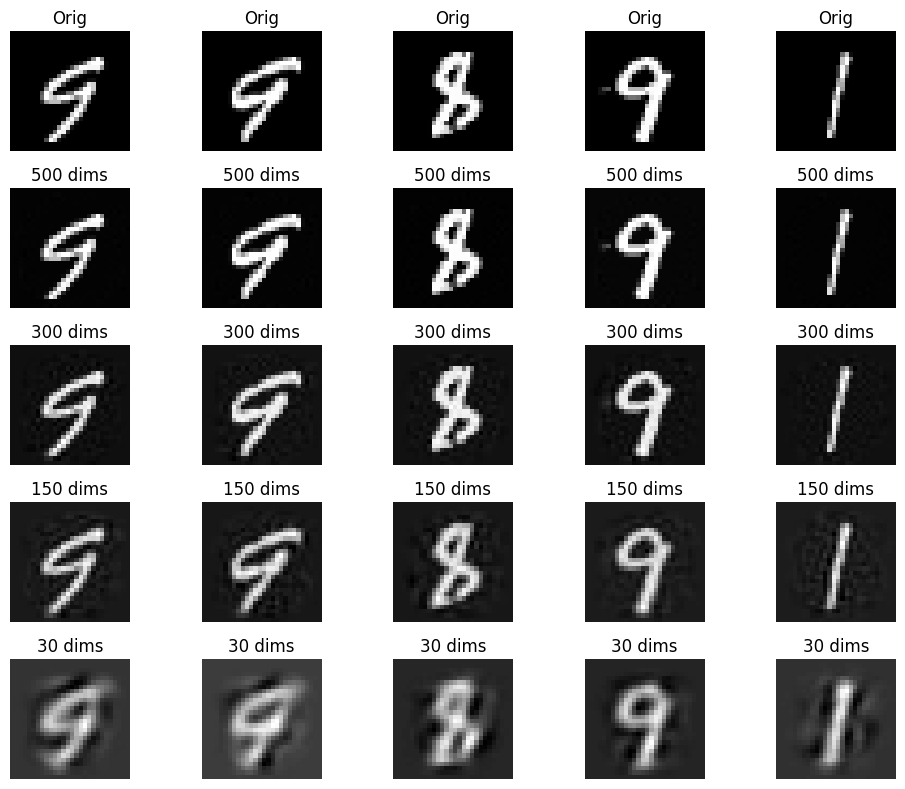

In [ ]:
fig, axs = plt.subplots(len(dims)+1, 5, figsize=(10,8))

sample_idx = [0, 1, 2, 3, 4] 

# originals
for j,i in enumerate(sample_idx):
    axs[0,j].imshow(X[i].reshape(28,28), cmap='gray')
    axs[0,j].set_title("Orig")
    axs[0,j].axis("off")

# reconstructions
for r,d in enumerate(dims):
    X_hat = results[d]["X_hat"]
    for j,i in enumerate(sample_idx):
        axs[r+1,j].imshow(X_hat[i].reshape(28,28), cmap='gray')
        axs[r+1,j].set_title(f"{d} dims")
        axs[r+1,j].axis("off")

plt.tight_layout()
plt.show()


500 components: reconstructions are almost identical to originals.

300 components: digits remain sharp; minor smoothing.

150 components: recognizable but blurrier, some detail loss.

30 components: digits look fuzzy but still distinguishable.